In [1]:
import os
import numpy as np
import pandas as pd
from os.path import join as pjoin
from scipy.stats.stats import sem, zscore
from matplotlib import pyplot as plt
from cxy_visual_dev.lib.predefine import dataset_name2info, proj_dir

anal_dir = pjoin(proj_dir, 'analysis')
work_dir = pjoin(anal_dir, 'plot/plot_age_line')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

# plot same column of CSV files in one axis

In [21]:
def plot_same_cols_in_one_ax(fpaths, age_name, columns, n_row, n_col, yerr_flag=True, zscore_flag=False, info_file=None,
                             ylabel=None, title='col_name', labels=None, figsize=None, remove_ages=[],
                             out_file=None):
    """
    把多个文件中同名的column画到同一个axis里，不同名的column画到不同axis里

    Args:
        fpaths (str | strings):
            不同文件的行要统一
        age_name (str): column name of age
        columns (str | strings): 指定要画的列
            'all': all columns of fpaths[0]
            len(columns) <= n_row * n_col
        n_row (int): axes的行数
        n_col (int): axes的列数
        yerr_flag (bool, optional): Defaults to True
            True: 显示errorbar
        zscore_flag (bool, optional): Defaults to False.
            True: 在画线之前进行zscore
        info_file (str, optional): Defaults to None.
            如果提供这个文件，则在该文件中找age信息
            不然就从fpaths[0]里找
        ylabel (str, optional): Defaults to None.
        title (str, optional): Defaults to 'col_name'.
            None: 不显示标题
            'col_name': 以对应的列名做为每个axis的标题
            其它字符串：在第一行中间的axis上显示该字符串为标题
        labels (strings, optional): Defaults to None.
            和文件一一对应，标记对应曲线的label。
        figsize (tuple, optional): Defaults to None.
        remove_ages (integers, optional): Defaults to [].
            去掉这些年龄
        out_file (str, optional): Defaults to None.
            None: 只画不存
    """
    if isinstance(fpaths, str):
        fpaths = [fpaths]
    n_file = len(fpaths)
    dfs = [pd.read_csv(i) for i in fpaths]
    if info_file is None:
        ages = np.array(dfs[0][age_name])
    else:
        info_df = pd.read_csv(info_file)
        ages = np.array(info_df[age_name])
    age_uniq = np.unique(ages).tolist()
    for i in remove_ages:
        age_uniq.remove(i)
    n_age = len(age_uniq)

    if columns == 'all':
        columns = dfs[0].columns.to_list()
    elif isinstance(columns, str):
        columns = [columns]
    n_col = len(columns)
    assert n_col <= n_row * n_col

    if labels is None:
        labels = [None] * n_file
    elif isinstance(labels, str):
        labels = [labels] * n_file
    else:
        assert len(labels) == n_file

    _, axes = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row == 1 and n_col == 1:
        axes = np.array([[axes]])
    elif axes.shape != (n_row, n_col):
        axes = axes.reshape((n_row, n_col))
    max_row_idx = int((n_col-1) / n_col)
    for column_idx, col in enumerate(columns):
        row_idx = int(column_idx / n_col)
        col_idx = column_idx % n_col
        ax = axes[row_idx, col_idx]
        for f_idx, df in enumerate(dfs):
            meas_vec = np.array(df[col])
            y = np.zeros(n_age, np.float64)
            yerr = np.zeros(n_age, np.float64)
            for age_idx, age in enumerate(age_uniq):
                meas_tmp = meas_vec[ages == age]
                meas_tmp = meas_tmp[~np.isnan(meas_tmp)]
                n_meas = len(meas_tmp)
                if n_meas in (0, 1):
                    raise ValueError(f'#{labels[f_idx]}-{age}:', n_meas)
                elif n_meas < 10:
                    print(f'#{labels[f_idx]}-{age}:', n_meas)
                if zscore_flag:
                    meas_tmp = zscore(meas_tmp)
                y[age_idx] = np.mean(meas_tmp)
                yerr[age_idx] = sem(meas_tmp)
            if yerr_flag:
                ax.errorbar(age_uniq, y, yerr, label=labels[f_idx])
            else:
                ax.errorbar(age_uniq, y, label=labels[f_idx])
        ax.legend()
        if col_idx == 0 and ylabel is not None:
            ax.set_ylabel(ylabel)
        if row_idx == max_row_idx:
            ax.set_xlabel(age_name)
        if title is None:
            pass
        elif title == 'col_name':
            ax.set_title(col)
        else:
            if row_idx == 0 and col_idx == int(n_col/2):
                ax.set_title(title)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if out_file is None:
        plt.show()
    else:
        plt.savefig(out_file)

#ALFF-36: 8
#GBC-36: 8


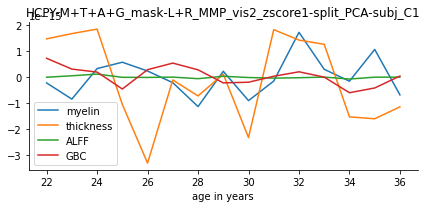

In [26]:
plot_same_cols_in_one_ax(
    fpaths=[
        pjoin(anal_dir, 'PCA/HCPY-M+T+A+G_mask-L+R_MMP_vis2_zscore1-split_PCA-subj_M.csv'),
        pjoin(anal_dir, 'PCA/HCPY-M+T+A+G_mask-L+R_MMP_vis2_zscore1-split_PCA-subj_T.csv'),
        pjoin(anal_dir, 'PCA/HCPY-M+T+A+G_mask-L+R_MMP_vis2_zscore1-split_PCA-subj_A.csv'),
        pjoin(anal_dir, 'PCA/HCPY-M+T+A+G_mask-L+R_MMP_vis2_zscore1-split_PCA-subj_G.csv')
    ], age_name='age in years', columns='C1', n_row=1, n_col=1, yerr_flag=False, zscore_flag=True,
    info_file=dataset_name2info['HCPY'], title='HCPY-M+T+A+G_mask-L+R_MMP_vis2_zscore1-split_PCA-subj_C1',
    labels=['myelin', 'thickness', 'ALFF', 'GBC'], figsize=(6, 3), remove_ages=[37],
    out_file=pjoin(work_dir, 'HCPY-M+T+A+G_mask-L+R_MMP_vis2_zscore1-split_PCA-subj_C1.jpg')
)